In [1]:
# Standard Libraries
import os
import random
import warnings

# Data Manipulation
import numpy as np
import pandas as pd
from collections import Counter

# Machine Learning Libraries
import scipy
import sklearn
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.utils import class_weight

# Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Image Processing
import imageio
import skimage
import skimage.io
import skimage.transform
from PIL import Image

# TensorFlow and Keras
import tensorflow as tf
import tensorflow.keras
from tensorflow.keras import optimizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Dense,
    Conv2D,
    Flatten,
    MaxPool2D,
    Dropout,
    BatchNormalization,
    LeakyReLU,
)
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import (
    ModelCheckpoint,
    Callback,
    EarlyStopping,
    ReduceLROnPlateau,
)
from tensorflow.keras.applications import VGG16
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.metrics import Recall

import itertools

# set cuda lib path
os.environ["XLA_FLAGS"] = "--xla_gpu_cuda_data_dir=/opt/cuda"

2023-10-04 10:58:10.836676: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-10-04 10:58:10.859113: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9241] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-10-04 10:58:10.859138: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-10-04 10:58:10.859789: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1516] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-10-04 10:58:10.863663: I tensorflow/core/platform/cpu_feature_guar

In [2]:
TRAIN_FILE = "./data/bees_train.csv"
TEST_FILE = "./data/bees_test.csv"
IMG_FOLDER = "./data/imgs/"
IMG_SIZE = 128  # this is the size of the images that we'll use (to resize original images to this size)

In [3]:
train_df = pd.read_csv(TRAIN_FILE)
test_df = pd.read_csv(TEST_FILE)

CLASS_COUNT = len(train_df["subspecies"].unique())

In [4]:
print(train_df.head())

   id             datetime          file             location  zip code  \
0   0  2018-08-06 14:48:00   020_011.png    Saratoga, CA, USA     95070   
1   1  2018-08-21 09:00:00   032_507.png  Des Moines, IA, USA     50315   
2   2  2018-08-21 09:00:00   032_612.png  Des Moines, IA, USA     50315   
3   3  2018-08-17 17:50:00   030_773.png       Alvin, TX, USA     77511   
4   4  2018-08-06 13:19:00  015_1052.png    Saratoga, CA, USA     95070   

          subspecies        health  pollen_carrying   caste  
0  Italian honey bee       healthy            False  worker  
1  Russian honey bee       healthy            False  worker  
2  Russian honey bee       healthy            False  worker  
3  Italian honey bee  ant problems            False  worker  
4  Italian honey bee       healthy            False  worker  


In [5]:
print(train_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3465 entries, 0 to 3464
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   id               3465 non-null   int64 
 1   datetime         3465 non-null   object
 2   file             3465 non-null   object
 3   location         3465 non-null   object
 4   zip code         3465 non-null   int64 
 5   subspecies       3465 non-null   object
 6   health           3465 non-null   object
 7   pollen_carrying  3465 non-null   bool  
 8   caste            3465 non-null   object
dtypes: bool(1), int64(2), object(6)
memory usage: 220.1+ KB
None


In [6]:
print(train_df["subspecies"].value_counts())

subspecies
Italian honey bee        2010
Russian honey bee         360
Carniolan honey bee       344
1 Mixed local stock 2     301
-1                        282
VSH Italian honey bee     146
Western honey bee          22
Name: count, dtype: int64


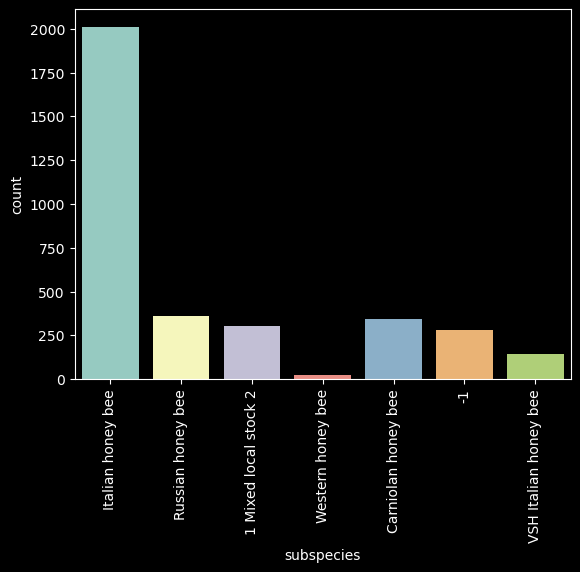

In [7]:
sns.countplot(data=train_df, x="subspecies")
plt.xticks(rotation=90)  # Rotate x-axis labels to be vertical
plt.show()

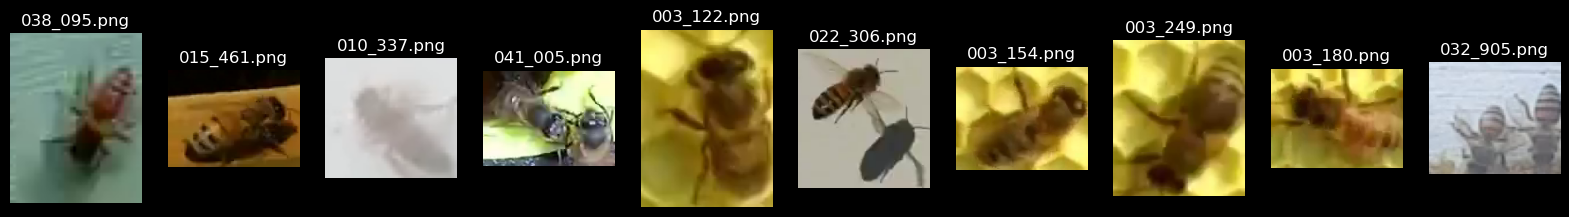

In [8]:
# List all files in the folder
all_files = os.listdir(IMG_FOLDER)

# Randomly select 10 image files
random_files = random.sample(all_files, 10)

# Create a figure and multiple subplots
fig, axes = plt.subplots(1, len(random_files), figsize=(20, 5))

for ax, image_file in zip(axes, random_files):
    # Create the full image path
    full_image_path = os.path.join(IMG_FOLDER, image_file)

    # Open the image using PIL
    image = Image.open(full_image_path)

    # Display the image in the corresponding subplot
    ax.imshow(image)
    ax.set_title(image_file)
    ax.axis("off")

plt.show()

In [9]:
# List all files in the folder
all_files = os.listdir(IMG_FOLDER)

# Initialize a list to store dimensions
image_dimensions = []

# Loop through each file to get its dimensions
for image_file in all_files:
    # Create the full image path
    full_image_path = os.path.join(IMG_FOLDER, image_file)

    # Open the image using PIL
    with Image.open(full_image_path) as img:
        # Get dimensions
        width, height = img.size
        image_dimensions.append((width, height))

widths = [dim[0] for dim in image_dimensions]
heights = [dim[1] for dim in image_dimensions]

print(f"Mean Width: {np.mean(widths):.2f}, Mean Height: {np.mean(heights):.2f}")
print(f"Median Width: {np.median(widths):.2f}, Median Height: {np.median(heights):.2f}")
print(f"Std Dev Width: {np.std(widths):.2f}, Std Dev Height: {np.std(heights):.2f}")

Mean Width: 74.42, Mean Height: 72.01
Median Width: 62.00, Median Height: 61.00
Std Dev Width: 41.21, Std Dev Height: 40.46


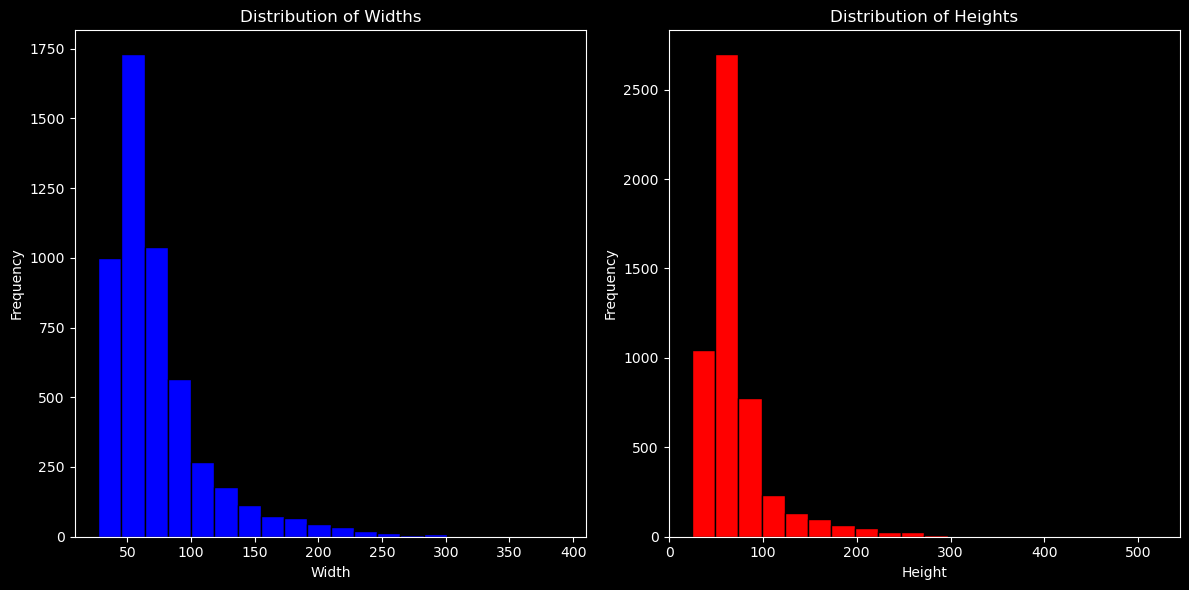

In [10]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.hist(widths, bins=20, color="blue", edgecolor="black")
plt.title("Distribution of Widths")
plt.xlabel("Width")
plt.ylabel("Frequency")

plt.subplot(1, 2, 2)
plt.hist(heights, bins=20, color="red", edgecolor="black")
plt.title("Distribution of Heights")
plt.xlabel("Height")
plt.ylabel("Frequency")

plt.tight_layout()
plt.show()

In [11]:
print(f"25th percentile of widths: {np.percentile(widths, 25)}")
print(f"75th percentile of widths: {np.percentile(widths, 75)}")
print(f"25th percentile of heights: {np.percentile(heights, 25)}")
print(f"75th percentile of heights: {np.percentile(heights, 75)}")

25th percentile of widths: 48.0
75th percentile of widths: 84.0
25th percentile of heights: 51.0
75th percentile of heights: 76.0


## Challenges in the Dataset

### 1. Varying Image Sizes

#### Problem:
The dataset contains images of varying dimensions, making it difficult to feed them into a machine learning model that expects a fixed-size input.

#### Solution Ideas:
- **Resizing**: All images could be resized to a standard dimension before feeding them into the model.
- **Padding**: Add padding to the images to make them all the same size, filling the extra space with a constant value (e.g., zero).
- **Data Augmentation**: Use techniques like cropping to generate multiple fixed-size pieces from each original image, effectively increasing the dataset size.

---

### 2. Class Imbalance

#### Problem:
The dataset suffers from class imbalance, with one class having a majority of examples and another having very few. This could lead to a biased model that performs poorly on under-represented classes.

#### Solution Ideas:
- **Resampling**: 
  - **Oversampling**: Duplicate examples from the minority class or generate synthetic examples.
  - **Undersampling**: Reduce the number of examples from the majority class.
- **Class Weights**: Use weighted loss functions to give higher importance to under-represented classes during training.
- **Cost-sensitive Learning**: Modify the learning algorithm to be sensitive to the class imbalance.

---

By addressing these challenges, we aim to build a more robust and fair classification model.


In [12]:
from tensorflow.keras import backend as K

def get_image_train_data_generator(df):
    # Initialize data augmentation
    train_datagen = ImageDataGenerator(
        rescale=1.0 / 255,
        rotation_range=90,
        zoom_range=0.15,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.15,
        horizontal_flip=True,
        vertical_flip=True,
        fill_mode="nearest",
    )

    # Create the training data generator
    train_generator = train_datagen.flow_from_dataframe(
        dataframe=train_df,
        directory=IMG_FOLDER,
        x_col="file",
        y_col="subspecies",
        target_size=(IMG_SIZE, IMG_SIZE),
        batch_size=32,
        class_mode="categorical",
    )

    return train_generator


def get_image_data_generator(df):
    train_df, val_df = train_test_split(
        df, test_size=0.10, shuffle=True, stratify=df["subspecies"]
    )

    # Create the training data generator
    train_generator = get_image_train_data_generator(train_df)
    
    # Create the validation data generator
    val_datagen = ImageDataGenerator(rescale=1.0 / 255)
    val_generator = val_datagen.flow_from_dataframe(
        dataframe=val_df,
        directory=IMG_FOLDER,
        x_col="file",
        y_col="subspecies",
        target_size=(IMG_SIZE, IMG_SIZE),
        batch_size=32,
        class_mode="categorical",
    )

    return train_generator, val_generator, train_df, val_df


# metrics_list = []
# for i in range(CLASS_COUNT):
#     metrics_list.append(Recall(class_id=i, name=f'recall_class_{i}'))


def macro_average_recall(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)), axis=0)
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)), axis=0)
    recall_per_class = true_positives / (possible_positives + K.epsilon())
    macro_avg_recall = K.mean(recall_per_class)
    return macro_avg_recall


def create_model(train_df, optimizer="Adam", learning_rate=0.001, dropout=0.5):
    if optimizer == "Adam":
        optimizer = Adam(learning_rate=learning_rate)
    else:
        optimizer = SGD(learning_rate=learning_rate)

    # Load the VGG16 network with its head layers removed
    baseModel = VGG16(
        weights="imagenet", include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3)
    )

    # Create the head of the model
    headModel = baseModel.output
    headModel = layers.Flatten(name="flatten")(headModel)
    headModel = layers.Dense(512, activation="relu")(headModel)
    headModel = layers.Dropout(dropout)(headModel)
    headModel = layers.Dense(CLASS_COUNT, activation="softmax")(headModel)

    # Combine base model and head model
    model = Model(inputs=baseModel.input, outputs=headModel)

    # Compile the model
    opt = Adam(learning_rate=1e-4)
    model.compile(
        loss="categorical_crossentropy", optimizer=opt, metrics=[macro_average_recall]
    )
    return model


def evaluate_model(model, val_datagen):
    loss, macro_avg_recall = model.evaluate(val_datagen)
    print(f"Loss: {loss:.4f}, Macro Average Recall: {macro_avg_recall:.4f}")
    return macro_avg_recall


def train_model(
    model,
    train_generator,
    train_df,
    val_generator,
    val_df,
    class_weights,
    epochs=100,
    batch_size=32,
):
    early_stopping = EarlyStopping(
        monitor="val_loss",
        patience=30,
        verbose=1,
        mode="min",
        restore_best_weights=True,
    )
    model.fit(
        train_generator,
        steps_per_epoch=len(train_df) // batch_size,
        validation_data=val_generator,
        validation_steps=len(val_df) // batch_size,
        class_weight=class_weights,
        epochs=epochs,
        callbacks=[early_stopping],
    )
    stopped_epoch = early_stopping.stopped_epoch
    return model, stopped_epoch


def find_best_hyperparametrs(train_df, cv, param_grid, class_weights):
    best_recall = 0
    best_combination = None
    best_model = None
    keys, values = zip(*param_grid.items())
    combinations = [dict(zip(keys, v)) for v in itertools.product(*values)]
    counter = 0
    for combination in combinations:
        epoch, batch_size, optimizer, learning_rate, dropout = combination.values()
        stopped_epoch = epoch
        counter += 1
        print(
            f"Combination: {counter}/{len(combinations)} Epoch: {epoch}, Batch Size: {batch_size}, Optimizer: {optimizer}, Learning Rate: {learning_rate}, Dropout: {dropout}"
        )

        # iterate over the folds
        for i in range(cv):
            print(f"Fold: {i+1}/{cv}")
            train_generator, val_generator, train_df, val_df = get_image_data_generator(
                train_df
            )
            model = create_model(train_df, optimizer, learning_rate, dropout)
            model, stopped_epoch = train_model(
                model,
                train_generator,
                train_df,
                val_generator,
                val_df,
                class_weights,
                epoch,
                batch_size,
            )

            recall = evaluate_model(model, val_generator)

        if recall > best_recall:
            best_recall = recall
            best_combination = combination.copy()
            best_combination['stopped_epoch'] = stopped_epoch if stopped_epoch > 0 else epoch
            best_model = model
    return best_model, best_combination


y = np.array(train_df["subspecies"].astype("category").cat.codes)
class_weights = class_weight.compute_class_weight("balanced", classes=np.unique(y), y=y)
class_weights_dict = {i: class_weights[i] for i in range(len(class_weights))}

param_grid = {
    "epochs": [500],
    "batch_size": [32, 64],
    "optimizer": ["SGD", "Adam"],
    "learning_rate": [0.0001, 0.001],
    "dropout": [0.3, 0.4, 0.5],
}

# param_grid = {
#     "epochs": [2],
#     "batch_size": [32],
#     "optimizer": ["SGD", "Adam"],
#     "learning_rate": [0.1],
#     "dropout": [0.3],
# }


_, best_combination = find_best_hyperparametrs(
    train_df, 5, param_grid, class_weights_dict
)

print(best_combination)
print("Train with the best hyperparameters and all data")
train_generator = get_image_train_data_generator(train_df)

model = create_model(
    train_df,
    best_combination['optimizer'],
    best_combination['learning_rate'],
    best_combination['dropout'],
)
model = train_model(
    model,
    train_generator,
    train_df,
    train_generator,
    train_df,
    class_weights_dict,
    best_combination['stopped_epoch'],
    best_combination['batch_size'],
)

Combination: 1/24 Epoch: 500, Batch Size: 32, Optimizer: SGD, Learning Rate: 0.0001, Dropout: 0.3
Fold: 1/5
Found 3465 validated image filenames belonging to 7 classes.
Found 347 validated image filenames belonging to 7 classes.


2023-10-04 10:58:12.159505: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:913] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-10-04 10:58:12.174028: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:913] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-10-04 10:58:12.174177: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:913] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

Epoch 1/500


2023-10-04 10:58:13.529349: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:440] Loaded cuDNN version 8902
2023-10-04 10:58:14.259627: I external/local_xla/xla/service/service.cc:168] XLA service 0x7fa050212600 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-10-04 10:58:14.259668: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3080 Ti, Compute Capability 8.6
2023-10-04 10:58:14.262924: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1696427894.320999 1800711 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


 5/97 [>.............................] - ETA: 3s - loss: 2.0156 - macro_average_recall: 0.0000e+00

In [ ]:
best_combination